In [1]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
#read in data
mb = pd.read_csv("/Users/ajaypatel8/Downloads/Metabolic Syndrome.csv")

In [3]:
#create X and y for modeling
X = mb.drop('MetabolicSyndrome', axis=1)
y = mb['MetabolicSyndrome']

#impute missing values
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

X[numerical_cols] = imputer_num.fit_transform(X[numerical_cols])
X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])

In [4]:
#convert categorical columns into numeric form
sex_label_encoder=LabelEncoder()
X["Sex"]=sex_label_encoder.fit_transform(X["Sex"])

marital_label_encoder=LabelEncoder()
X["Marital"]=marital_label_encoder.fit_transform(X["Marital"])

race_label_encoder=LabelEncoder()
X["Race"]=race_label_encoder.fit_transform(X["Race"])

In [5]:
#check for null values, none left so we're good to go
X.isnull().sum()

seqn             0
Age              0
Sex              0
Marital          0
Income           0
Race             0
WaistCirc        0
BMI              0
Albuminuria      0
UrAlbCr          0
UricAcid         0
BloodGlucose     0
HDL              0
Triglycerides    0
dtype: int64

In [6]:
#scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

#make train and test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
#initialize random forest
rf_model = RandomForestClassifier(random_state=42)

#make parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)

#get model with best performance
best_rf_model = grid_search_rf.best_estimator_

#perform cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=cv, scoring='accuracy')

#print the cv scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

#fit the model
best_rf_model.fit(X_train, y_train)

#make predictions
y_pred_rf = best_rf_model.predict(X_test)

#evaluate by accuracy, f1 score, and confusion matrix
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest F1 Score: {f1_rf:.4f}")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Cross-validation scores: [0.89322917 0.88541667 0.88020833 0.83854167 0.8828125 ]
Mean CV accuracy: 0.8760416666666666
Random Forest Accuracy: 0.8669
Random Forest F1 Score: 0.7881


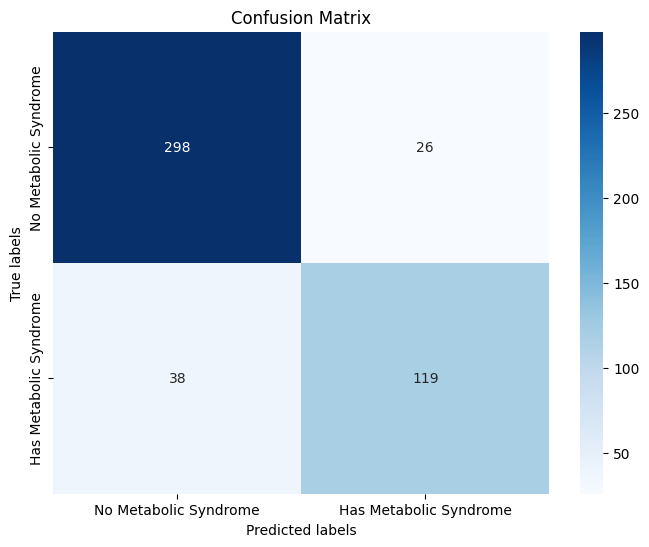

In [8]:
#labels for conf matrix
labels = ['No Metabolic Syndrome', 'Has Metabolic Syndrome']

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

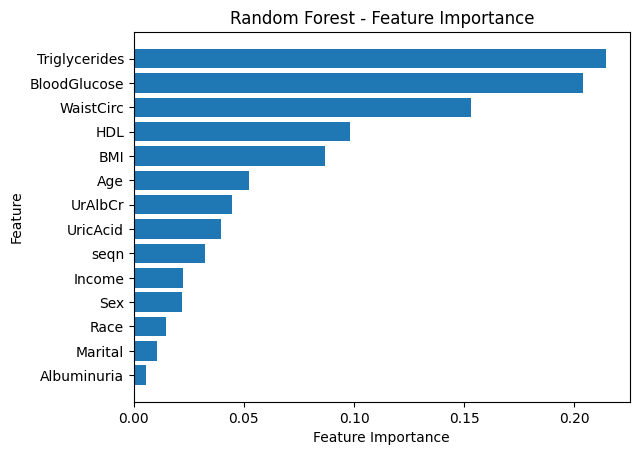

In [10]:
#get feature names and importances
feature_names = X.columns
feature_importance = best_rf_model.feature_importances_

#sort the feature importance
sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=False)

#plot feature importance
features, importance = zip(*sorted_feature_importance)
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest - Feature Importance')
plt.show()